# Comparing machine learning approaches to predict SEEG accuracy

Stereoencephalography (SEEG) is a technique used in drug-resistant epilepsy patients that may be a candidate for surgical resection of the epileptogenic zone. Multiple electrodes are placed using a so-called "frame based" stereotactic approach, in our case using the [Leksell frame](https://www.elekta.com/neurosurgery/leksell-stereotactic-system/). In our previous paper "[Methodology, outcome, safety and in vivo accuracy in traditional frame-based stereoelectroencephalography](https://www.ncbi.nlm.nih.gov/pubmed/28676892)" by Van der Loo et al (2017) we reported on SEEG electrode implantation accuracy in a cohort of 71 patients who were operated between September 2008 and April 2016. This resulted in a dataset of 902 electrodes. 

The goal of the current project is to use a public version of this dataset (without any personal identifiers) to predict implantation accuracy by using and comparing different machine learning approaches. 

Pieter Kubben, MD, PhD<br/>
neurosurgeon<br/>
Maastricht University Medical Center<br/>
The Netherlands

For any questions you can reach me by [email](mailto:p.kubben@mumc.nl) or on [Twitter](http://twitter.com/DigNeurosurgeon).

## Data description

The public dataset contains these variables:

- PatientPosition
- Contacts
- ElectrodeType
- PlanningX
- PlanningY
- PlanningZ
- PlanningRing
- PlanningArc
- DuraTipDistancePlanned
- EntryX
- EntryY
- EntryZ
- TipX
- TipY
- TipZ
- SkinSkullDistance
- SkullThickness
- SkullAngle
- ScrewLength

> check [FAIR data](https://www.nature.com/articles/sdata201618) and [FAIR guiding principles](https://www.nature.com/articles/sdata201618#bx2)

In [110]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
# import warnings; warnings.simplefilter('ignore')

# global setting whether to save figures or not
save_figures = False

In [122]:
# load data
electrodes = pd.read_csv('electrodes_public.csv')

# find missing values
nan_rows = sum([True for idx,row in electrodes.iterrows() if any(row.isnull())])
print('Nr of rows with missing values:', nan_rows)

Nr of rows with missing values: 823


In [118]:
# calculate TPLE and remove entry data from dataframe
electrodes['TPLE'] = np.sqrt(np.square(electrodes['TipX'] - electrodes['PlanningX']) + 
                              np.square(electrodes['TipY'] - electrodes['PlanningY']) + 
                              np.square(electrodes['TipZ'] - electrodes['PlanningZ'])
                             ).round(1)
electrodes.drop(['EntryX', 'EntryY', 'EntryZ'], axis = 1, inplace = True)
electrodes.head()

,PatientPosition,Contacts,ElectrodeType,PlanningX,PlanningY,PlanningZ,PlanningRing,PlanningArc,DuraTipDistancePlanned,TipX,TipY,TipZ,SkinSkullDistance,SkullThickness,SkullAngle,ScrewLength,TPLE
0,Supine,18.0,Oblique,125.8,106.5,135.5,154.6,90.2,86.6,126.4,106.8,135.2,7.0,9.7,70.3,25.0,0.7
1,Supine,18.0,Oblique,130.6,131.0,136.4,155.4,96.6,105.9,134.7,132.9,136.0,9.4,7.4,63.8,30.0,4.5
2,Supine,10.0,Oblique,139.1,104.9,124.0,131.1,146.0,35.2,139.1,108.3,124.4,9.8,5.5,66.4,30.0,3.4
3,Supine,10.0,Oblique,137.7,112.2,115.0,96.2,137.1,35.9,136.4,115.2,115.0,8.4,6.5,66.3,25.0,3.3
4,Supine,12.0,Oblique,126.0,76.0,124.1,159.1,156.3,39.5,124.6,75.8,126.8,7.4,4.6,84.7,25.0,3.0


In [119]:
# check for outliers in Z axis
large_depth_error = electrodes[np.abs(electrodes['PlanningZ'] - electrodes['TipZ']) > 10]
print('Outliers in Z axis (> 10mm):\n\n', large_depth_error['TPLE'])

# remove outliers
electrodes.drop(large_depth_error.index, inplace = True)
print('\nNew dataframe shape:', electrodes.shape) # removed 6 rows

Outliers in Z axis (> 10mm):

 446    14.8
462    14.5
463    11.2
508    45.8
612    14.2
632    20.0
Name: TPLE, dtype: float64

New dataframe shape: (860, 17)


In [121]:
# convert categorical columns to "category" dtype
catcols = ['PatientPosition', 'Contacts', 'ElectrodeType', 'ScrewLength']
for cat in catcols:
    electrodes[cat] = electrodes[cat].astype('category')

# confirm correct types for all columns now
electrodes.dtypes

PatientPosition           category
Contacts                  category
ElectrodeType             category
PlanningX                  float64
PlanningY                  float64
PlanningZ                  float64
PlanningRing               float64
PlanningArc                float64
DuraTipDistancePlanned     float64
TipX                       float64
TipY                       float64
TipZ                       float64
SkinSkullDistance          float64
SkullThickness             float64
SkullAngle                 float64
ScrewLength               category
TPLE                       float64
dtype: object

In [8]:
# get summary data on TPLE
tple = electrodes['TPLE']
tple.describe().round(1)

count    860.0
mean       3.4
std        2.3
min        0.2
25%        2.0
50%        2.9
75%        4.1
max       19.8
Name: TPLE, dtype: float64

We now have data in the right format, but need to convert the *continuous* outcome variables EPLE and TPLE to `categories` using `pd.cut()`.

In [9]:
# create different possible cuts to create categories
electrodes_3cat = pd.cut(tple, bins = [0, 2, 5, 50], labels = ['0 - 2', '2 - 5', '> 5'])
electrodes_4cat = pd.cut(tple, bins = [0, 2, 4, 6, 50], labels = ['0 - 2', '2 - 4', '4 - 6', '> 6'])
electrodes_4quart = pd.cut(tple, bins = [0, 2, 3, 4, 50], labels = ['0 - 2', '2 - 3', '3 - 4', '> 4'])
electrodes_5cat = pd.cut(tple, bins = [0, 1, 2, 5, 10, 50], labels = ['0 - 1', '1 - 2', '2 - 5', '5 - 10', '> 10'])
electrodes_6cat = pd.cut(tple, bins = [0, 1, 2, 5, 10, 20, 50], labels = ['0 - 1', '1 - 2', '2 - 5', '5 - 10', '10 - 20', '> 20'])
electrodes_7cat = pd.cut(tple, bins = [0, 1, 2, 4, 6, 8, 10, 50], labels = ['0 - 1', '1 - 2', '2 - 4', '4 - 6', '6 - 8', '8 - 10', '> 10'])

# apply cut to create TPLE category column
electrodes['TPLE category'] = electrodes_5cat
nr_of_y_categories = 5 # needed for keras MLP

# check correct conversion with first 15 rows
electrodes[['TPLE', 'TPLE category']].head(15).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
TPLE,0.7,4.5,3.4,3.3,3,1.8,2.3,4.2,4.8,3.4,3.9,3.6,7.4,4.2,4.4
TPLE category,0 - 1,2 - 5,2 - 5,2 - 5,2 - 5,1 - 2,2 - 5,2 - 5,2 - 5,2 - 5,2 - 5,2 - 5,5 - 10,2 - 5,2 - 5


In [10]:
# count nr of items in each category
electrodes[['TPLE', 'TPLE category']].groupby('TPLE category').count().transpose()

TPLE category,0 - 1,1 - 2,2 - 5,5 - 10,> 10
TPLE,50,184,492,112,22


## Visualization
Let's first get an impression of variable distributions.

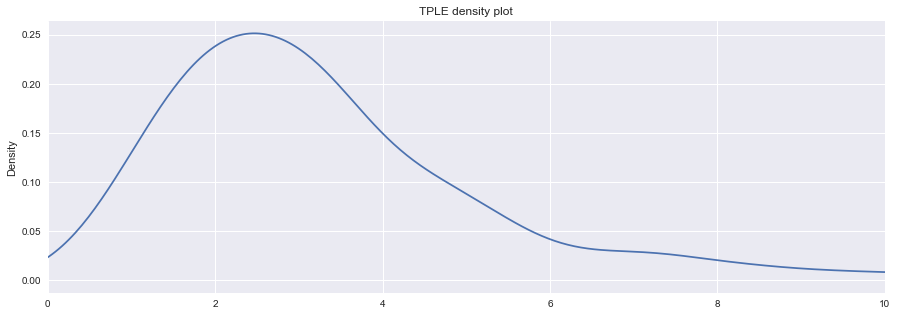

In [11]:
# create density plot
tple.plot(kind = 'density', figsize = (15,5), title = 'TPLE density plot');
plt.xlim(0,10);
if save_figures:
    plt.savefig('tple_density_plot.png', dpi = 300)

In [12]:
params = {'subplots': True, 'layout': (3,3), 'sharex': False, 'figsize': (12, 12)}
elec_visual = electrodes.drop(['TPLE'], axis = 1)
# elec_visual.plot(kind='density', **params);
# elec_visual.plot(kind='box', sharey = False, **params);

Now, how do they correlate with each other?

In [13]:
# sns.pairplot(elec_visual[['DuraTipDistancePlanned', 'SkinSkullDistance', 'SkullThickness', 'SkullAngle', 'PatientPosition', 'ScrewLength', 'TPLE category']], hue = 'TPLE category');

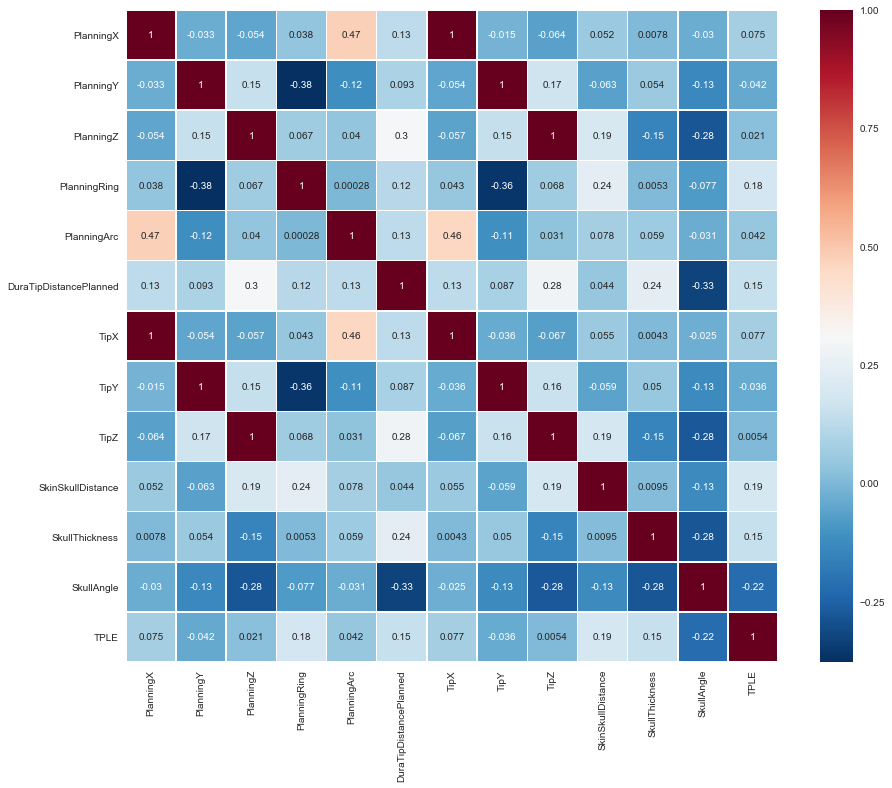

In [36]:
plt.figure(figsize = (15,12))
electrodes_dummies = pd.get_dummies(electrodes.drop(['TPLE category'], axis = 1))

# correlations for continuous variables only
sns.heatmap(electrodes.corr(), square = True, annot = True, linewidths = .5, cmap = 'RdBu_r');

# correlations including categorical variables
# sns.heatmap(electrodes_dummies.corr(), square = True, annot = False, cmap = 'RdBu_r');

# plt.tight_layout()
# plt.savefig('electrodes_corr_RdBu_r.png', dpi = 300)

## TPLE classification
Now we have our categories so let's classify...

In [84]:
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, Imputer
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
elec_features = electrodes.drop(['TPLE', 'TPLE category'], axis = 1)

for cat in catcols:
    elec_features[cat] = LabelEncoder().fit_transform(elec_features[cat])

X = elec_features # to start with
X = Imputer(strategy = 'most_frequent').fit_transform(X)
# X = VarianceThreshold(threshold=(.8 * (1 - .8))).fit_transform(X)
# X = PolynomialFeatures(2, interaction_only = True).fit_transform(X)
# X = SelectKBest(chi2, k = 5).fit_transform(X, y)
le = LabelEncoder()
y = le.fit_transform(electrodes['TPLE category'])

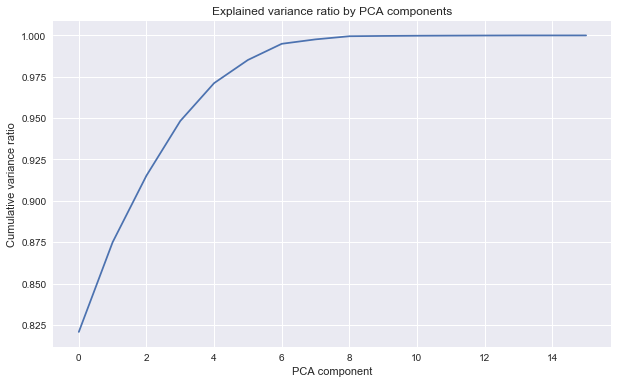

In [16]:
# dimensionality reduction using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = X.shape[1])
X_pca = pca.fit_transform(X)

# plot PCA variance ratio
plt.figure(figsize = (10,6));
plt.plot(pca.explained_variance_ratio_.cumsum());
plt.title('Explained variance ratio by PCA components');
plt.xlabel('PCA component');
plt.ylabel('Cumulative variance ratio');

In [17]:
# use principal components... reduces accuracy... so no, thanks
# X = PCA(3).fit_transform(X) # PCA n = 3 explains 95% of variance

In [85]:
# split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# check to see if shapes are consistent
def print_Xy_shapes():
    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    
# print_Xy_shapes()

In [19]:
# import modules
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

# prepare models
models = {'LOG': LogisticRegression(),
          'LDA': LinearDiscriminantAnalysis(),
          'KNN': KNeighborsClassifier(),
          'CART': DecisionTreeClassifier(),
          'NB': GaussianNB(),
          'SVM': SVC(),
          'LSVM1': LinearSVC(penalty='l1', dual = False),
          'LSVM2': LinearSVC(),
          'RF': RandomForestClassifier(),
          'ADA': AdaBoostClassifier(),
          'XGB': XGBClassifier()
         }

//anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [20]:
# evaluate each model in turn
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
names = []; results = []

for name, model in models.items():
    cv_results = cross_val_score(model, X_train, y_train, cv = KFold(10), scoring = 'accuracy')
    names.append(name)
    results.append(cv_results)
    print('{}: {:.2f} ({:.2f})'.format(name, cv_results.mean(), cv_results.std()))
    # print(classification_report(y_test, model.fit(X_train, y_train).predict(X_test), target_names = le.classes_))

LOG: 0.58 (0.07)
LDA: 0.56 (0.06)
KNN: 0.47 (0.04)
CART: 0.43 (0.06)
NB: 0.34 (0.04)
SVM: 0.57 (0.06)
LSVM1: 0.57 (0.06)
LSVM2: 0.41 (0.13)
RF: 0.51 (0.06)
ADA: 0.44 (0.05)
XGB: 0.54 (0.07)


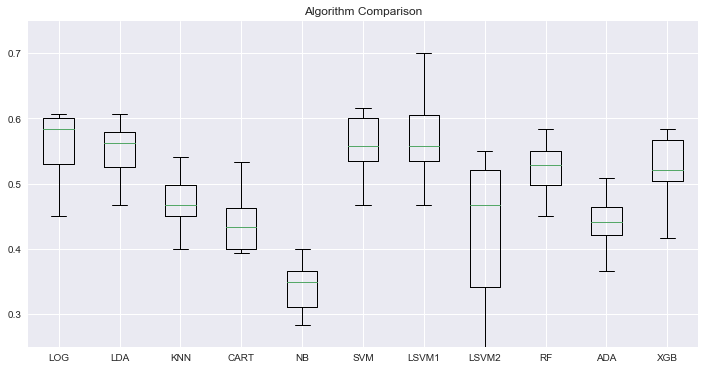

In [21]:
# boxplot algorithm comparison
fig = plt.figure(figsize = (12,6))
plt.title('Algorithm Comparison')
ax = fig.add_subplot(111)
ax.set_ylim(0.25, 0.75)
plt.boxplot(results)
ax.set_xticklabels(names); # set xtick labels after plotting! (otherwise default values override custom labels)

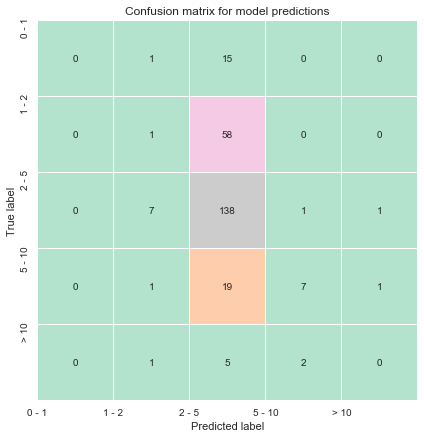

In [107]:
from sklearn.metrics import confusion_matrix
model = LogisticRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat_labels = sorted(list(electrodes['TPLE category'].unique()))
conf_mat = confusion_matrix(y_test, y_pred)
# conf_mat = confusion_matrix(y_test, y_pred, labels = conf_mat_labels)

plt.figure(figsize = (7, 7));
plt.title('Confusion matrix for model predictions')
sns.heatmap(conf_mat, annot = True, fmt = '.0f', cbar = False, square = True, cmap = 'Pastel2', linewidth = .5);
plt.xlabel('Predicted label');
plt.xticks(np.arange(5), conf_mat_labels);
plt.ylabel('True label');
plt.yticks(np.arange(5), conf_mat_labels);
# plt.savefig('sklearn_confusion_matrix.png')

In [108]:
from sklearn.metrics import accuracy_score, classification_report
print('Evaluation for:\n\n', model)
print('\n\nAccuracy score:', accuracy_score(y_test, y_pred).round(2))
print('\n\nClassification report: \n\n', classification_report(y_test, y_pred, target_names = conf_mat_labels))

Evaluation for:

 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Accuracy score: 0.57


Classification report: 

              precision    recall  f1-score   support

      0 - 1       0.00      0.00      0.00        16
      1 - 2       0.09      0.02      0.03        59
      2 - 5       0.59      0.94      0.72       147
     5 - 10       0.70      0.25      0.37        28
       > 10       0.00      0.00      0.00         8

avg / total       0.43      0.57      0.46       258



In [ ]:
from sklearn.model_selection import GridSearchCV
# SVC().get_params()
# svm_param_grid = [
#   {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
#   {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
#  ]
# svm_param_grid = {'kernel': ['linear', 'rbf'], 'C': [1, 10]} # simple and less slow... 
# svm_grid = GridSearchCV(SVC(), svm_param_grid, cv = 3, scoring = 'accuracy', n_jobs = -1)
# %time svm_grid.fit(X_train, y_train)

In [ ]:
# print('Best SVM params:', svm_grid.best_params_)
# print('Best SVM score:', svm_grid.best_score_.round(2))
# print('Best SVM model:\n', svm_grid.best_estimator_)

In [ ]:
# XGB tuning
# XGBClassifier().get_params()
xgb_param_grid = {'learning_rate': [0.001, 0.01, 0.1, 1.0],
                  'max_depth': [3, 5, 7],
                  'n_estimators': [100, 150, 200]
                 }
xgb_grid = GridSearchCV(XGBClassifier(), xgb_param_grid, cv = 3, scoring = 'accuracy', n_jobs = -1)
%time xgb_grid.fit(X_train, y_train)

In [ ]:
print('Best XGB params:', xgb_grid.best_params_)
print('Best XGB score:', xgb_grid.best_score_.round(2))
print('Best XGB model:\n', xgb_grid.best_estimator_)

In [ ]:
from xgboost import plot_tree
plt.figure(figsize = (15,7));
# plot_tree(xgb_grid.best_estimator_)
plot_tree(xgb_grid.best_estimator_, rankdir='LR');
# plt.savefig('xgbtree.png', dpi = 300)

### TPOT
Let's try TPOT for this purpose... note: a short test can be run using `TPOTClassifier(generations=5, population_size=50, verbosity=2)`.

In [109]:
from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=10, population_size=50, verbosity=2, n_jobs = -1)
tpot.fit(X_train, y_train)
print('\nTPOT score: ', tpot.score(X_test, y_test))
tpot.export('tpot_tple_classification.py')

Optimization Progress:  30%|███       | 90/300 [00:27<09:46,  2.79s/pipeline]

Generation 1 - Current best internal CV score: 0.5914553859083906


Optimization Progress:  46%|████▌     | 137/300 [00:39<03:31,  1.30s/pipeline]

Generation 2 - Current best internal CV score: 0.594635102955596


Optimization Progress:  62%|██████▏   | 186/300 [00:51<01:19,  1.43pipeline/s]

Generation 3 - Current best internal CV score: 0.594635102955596


Optimization Progress:  78%|███████▊  | 233/300 [01:07<00:43,  1.55pipeline/s]

Generation 4 - Current best internal CV score: 0.5947191483401036


Generation 5 - Current best internal CV score: 0.5947191483401036

Best pipeline: GradientBoostingClassifier(input_matrix, GradientBoostingClassifier__learning_rate=0.01, GradientBoostingClassifier__max_depth=6, GradientBoostingClassifier__max_features=0.55, GradientBoostingClassifier__min_samples_leaf=10, GradientBoostingClassifier__min_samples_split=17, GradientBoostingClassifier__n_estimators=100, GradientBoostingClassifier__subsample=0.45)

TPOT score:  0.56976744186


## Deep learning (keras)

Multilayer Perceptron (MLP) for multi-class softmax classification

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
# print_Xy_shapes()

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=len(elec_features.columns)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nr_of_y_categories, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.fit(X_train, to_categorical(y_train), epochs=100, batch_size=10)

scores = model.evaluate(X_test, to_categorical(y_test), batch_size=128)
print('\n\n{}: {:.2f}'.format(model.metrics_names[1], scores[1]))

In [ ]:
from keras.utils import plot_model 
plot_model(model, show_shapes = True, to_file = 'keras_mlp.png') 